In [1]:

from functools import partial
from collections import OrderedDict
import torch
import torch.nn as nn
import tqdm
import os
import math
import argparse
import pandas as pd
from tqdm import tqdm
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def drop_path(x, drop_prob: float = 0., training: bool = False):
    """
    Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """
    Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class PatchEmbed(nn.Module):
    """
    2D Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_c=3, embed_dim=768, norm_layer=None):
        super().__init__()
        img_size = (img_size, img_size)
        patch_size = (patch_size, patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])  #(14,14)
        self.num_patches = self.grid_size[0] * self.grid_size[1]

        self.proj = nn.Conv2d(in_c, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()  #Identity无操作

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        #输入的h、w是固定的（224，224），否则会报错

        # flatten: [B, C, H, W] -> [B, C, HW]
        # transpose: [B, C, HW] -> [B, HW, C]
        x = self.proj(x).flatten(2).transpose(1, 2)  #flatten从第二维开始往后展平
        x = self.norm(x)
        return x


class Attention(nn.Module):
    def __init__(self,
                 dim,   # 输入token的dim
                 num_heads=8,
                 qkv_bias=False,
                 qk_scale=None,
                 attn_drop_ratio=0.,
                 proj_drop_ratio=0.):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5          #1/根号dk
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)   #一次性生成qkv，dim*3，可能有利于并行化，提高训练速度
        self.attn_drop = nn.Dropout(attn_drop_ratio)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop_ratio)

    def forward(self, x):
        # [batch_size, num_patches + 1, total_embed_dim]
        # batch_size一次传入的图片数，num_patches+1=14*14+1，total_embed_dim=768
        B, N, C = x.shape

        # qkv(): -> [batch_size, num_patches + 1, 3 * total_embed_dim]
        # reshape: -> [batch_size, num_patches + 1, 3, num_heads, embed_dim_per_head]
        # permute: -> [3, batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        # 3对应qkv三个参数，c就是total_embed_dim
        # 通过切片方式获得q、k、v各自的[batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        # transpose: -> [batch_size, num_heads, embed_dim_per_head, num_patches + 1]
        # @: multiply -> [batch_size, num_heads, num_patches + 1, num_patches + 1]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)  #dim=-1，对每一行进行softmax
        attn = self.attn_drop(attn)

        # @: multiply -> [batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        # transpose: -> [batch_size, num_patches + 1, num_heads, embed_dim_per_head]
        # reshape: -> [batch_size, num_patches + 1, total_embed_dim]
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Mlp(nn.Module):
    """
    MLP as used in Vision Transformer, MLP-Mixer and related networks
    """
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        #hidden_features为in_features的4倍，out_features再将dim还原为in_features
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Block(nn.Module):
    def __init__(self,
                 dim,
                 num_heads,
                 mlp_ratio=4.,
                 qkv_bias=False,
                 qk_scale=None,
                 drop_ratio=0.,         #多头注意力层最后的dropout
                 attn_drop_ratio=0.,    #softmax之后的一个dropout
                 drop_path_ratio=0.,    #Encoder Block的两个dropout
                 act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm):
        super(Block, self).__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
                              attn_drop_ratio=attn_drop_ratio, proj_drop_ratio=drop_ratio)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path_ratio) if drop_path_ratio > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop_ratio)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_c=3, num_classes=1000,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0, qkv_bias=True,
                 qk_scale=None, representation_size=None, distilled=False, drop_ratio=0.,
                 attn_drop_ratio=0., drop_path_ratio=0., embed_layer=PatchEmbed, norm_layer=None,
                 act_layer=None):
        """
        Args:
            img_size (int, tuple): input image size
            patch_size (int, tuple): patch size
            in_c (int): number of input channels
            num_classes (int): number of classes for classification head
            embed_dim (int): embedding dimension
            depth (int): depth of transformer  (Encoder block重复的次数)
            num_heads (int): number of attention heads
            mlp_ratio (int): ratio of mlp hidden dim to embedding dim
            qkv_bias (bool): enable bias for qkv if True
            qk_scale (float): override default qk scale of head_dim ** -0.5 if set
            representation_size (Optional[int]): enable and set representation layer ((pre-logits))to this value if set
            distilled (bool): model includes a distillation token and head as in DeiT models
            drop_ratio (float): dropout rate
            attn_drop_ratio (float): attention dropout rate
            drop_path_ratio (float): stochastic depth rate
            embed_layer (nn.Module): patch embedding layer
            norm_layer: (nn.Module): normalization layer
        """
        super(VisionTransformer, self).__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.num_tokens = 2 if distilled else 1 #针对DeiT models，此处不用管，默认为1
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        act_layer = act_layer or nn.GELU

        self.patch_embed = embed_layer(img_size=img_size, patch_size=patch_size, in_c=in_c, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))       #加入一个可训练参数，用zero矩阵进行初始化（batch、1、768）
        self.dist_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) if distilled else None
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + self.num_tokens, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_ratio)

        dpr = [x.item() for x in torch.linspace(0, drop_path_ratio, depth)]  # stochastic depth decay rule
        #linspace()在指定的间隔范围内(0, drop_path_ratio)返回均匀间隔(depth)的数字,drop_path_ratio是不断增长的
        #nn.Sequential顺序容器，将若干参数按顺序放入
        self.blocks = nn.Sequential(*[
            Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                  drop_ratio=drop_ratio, attn_drop_ratio=attn_drop_ratio, drop_path_ratio=dpr[i],
                  norm_layer=norm_layer, act_layer=act_layer)
            for i in range(depth)
        ])
        self.norm = norm_layer(embed_dim)

        # Representation layer
        if representation_size and not distilled:
            self.has_logits = True
            self.num_features = representation_size
            self.pre_logits = nn.Sequential(OrderedDict([
                ("fc", nn.Linear(embed_dim, representation_size)),
                ("act", nn.Tanh())
            ]))
        else:
            self.has_logits = False
            self.pre_logits = nn.Identity()

        # Classifier head(s)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()
        self.head_dist = None
        if distilled:
            self.head_dist = nn.Linear(self.embed_dim, self.num_classes) if num_classes > 0 else nn.Identity()

        # Weight init
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        if self.dist_token is not None:
            nn.init.trunc_normal_(self.dist_token, std=0.02)

        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(_init_vit_weights)

    def forward_features(self, x):
        # [B, C, H, W] -> [B, num_patches, embed_dim]
        x = self.patch_embed(x)  # [B, 196, 768]
        # [1, 1, 768] -> [B, 1, 768]
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        if self.dist_token is None:
            x = torch.cat((cls_token, x), dim=1)  # 在196维度进行cat [B, 197, 768]
        else:
            x = torch.cat((cls_token, self.dist_token.expand(x.shape[0], -1, -1), x), dim=1)

        x = self.pos_drop(x + self.pos_embed)
        x = self.blocks(x)
        x = self.norm(x)
        if self.dist_token is None:
            return self.pre_logits(x[:, 0])   #:跳过batch维度，通过切片方式将x索引为0的这一部分进行切片即cls_token
        else:
            return x[:, 0], x[:, 1]

    def forward(self, x):
        x = self.forward_features(x)
        if self.head_dist is not None:
            x, x_dist = self.head(x[0]), self.head_dist(x[1])
            if self.training and not torch.jit.is_scripting():
                # during inference, return the average of both classifier predictions
                return x, x_dist
            else:
                return (x + x_dist) / 2
        else:
            x = self.head(x)
        return x


def _init_vit_weights(m):
    """
    ViT weight initialization
    :param m: module
    """
    if isinstance(m, nn.Linear):
        nn.init.trunc_normal_(m.weight, std=.01)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode="fan_out")
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LayerNorm):
        nn.init.zeros_(m.bias)
        nn.init.ones_(m.weight)


def vit_base_patch16_224_in21k(num_classes: int = 21843, has_logits: bool = True):
    """
    ViT-Base model (ViT-B/16) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-21k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_patch16_224_in21k-e5005f0a.pth
    """
    model = VisionTransformer(img_size=224,
                              patch_size=16,
                              embed_dim=768,
                              depth=12,
                              num_heads=12,
                              representation_size=768 if has_logits else None,
                              num_classes=num_classes)
    return model


def vit_base_patch32_224_in21k(num_classes: int = 21843, has_logits: bool = True):
    """
    ViT-Base model (ViT-B/32) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-21k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_patch32_224_in21k-8db57226.pth
    """
    model = VisionTransformer(img_size=224,
                              patch_size=32,
                              embed_dim=768,
                              depth=12,
                              num_heads=12,
                              representation_size=768 if has_logits else None,
                              num_classes=num_classes)
    return model


def vit_large_patch16_224_in21k(num_classes: int = 21843, has_logits: bool = True):
    """
    ViT-Large model (ViT-L/16) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-21k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_large_patch16_224_in21k-606da67d.pth
    """
    model = VisionTransformer(img_size=224,
                              patch_size=16,
                              embed_dim=1024,
                              depth=24,
                              num_heads=16,
                              representation_size=1024 if has_logits else None,
                              num_classes=num_classes)
    return model


def vit_large_patch32_224_in21k(num_classes: int = 21843, has_logits: bool = True):
    """
    ViT-Large model (ViT-L/32) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-21k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    weights ported from official Google JAX impl:
    https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_large_patch32_224_in21k-9046d2e7.pth
    """
    model = VisionTransformer(img_size=224,
                              patch_size=32,
                              embed_dim=1024,
                              depth=24,
                              num_heads=16,
                              representation_size=1024 if has_logits else None,
                              num_classes=num_classes)
    return model


def vit_huge_patch14_224_in21k(num_classes: int = 21843, has_logits: bool = True):
    """
    ViT-Huge model (ViT-H/14) from original paper (https://arxiv.org/abs/2010.11929).
    ImageNet-21k weights @ 224x224, source https://github.com/google-research/vision_transformer.
    NOTE: converted weights not currently available, too large for github release hosting.
    """
    model = VisionTransformer(img_size=224,
                              patch_size=14,
                              embed_dim=1280,
                              depth=32,
                              num_heads=16,
                              representation_size=1280 if has_logits else None,
                              num_classes=num_classes)
    return model


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from PIL import Image
import torch
from torch.utils.data import Dataset

# 数据集类
class APTOSDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None, has_labels=True):
        self.labels_frame = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.has_labels = has_labels

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        img_name = self.labels_frame.iloc[idx, 0]
        image = Image.open(f"{self.root_dir}/{img_name}.png")

        if self.transform:
            image = self.transform(image)
        if self.has_labels:
          label = self.labels_frame.iloc[idx, 1]
          return image, label
        else:
          return image, _
        
    @staticmethod
    def collate_fn(batch):
        # 官方实现的default_collate可以参考
        # https://github.com/pytorch/pytorch/blob/67b7e751e6b5931a9f45274653f4f653a4e6cdf6/torch/utils/data/_utils/collate.py
        images, labels = tuple(zip(*batch))

        images = torch.stack(images, dim=0)
        labels = torch.as_tensor(labels)
        return images, labels

In [3]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    loss_function = torch.nn.CrossEntropyLoss()
    accu_loss = torch.zeros(1).to(device)  # 累计损失
    accu_num = torch.zeros(1).to(device)   # 累计预测正确的样本数
    optimizer.zero_grad()#梯度置零

    sample_num = 0
    data_loader = tqdm(data_loader)#进度提示信息
    for step, data in enumerate(data_loader):
        images, labels = data
        sample_num += images.shape[0]

        pred = model(images.to(device))
        pred_classes = torch.max(pred, dim=1)[1]
        accu_num += torch.eq(pred_classes, labels.to(device)).sum()

        loss = loss_function(pred, labels.to(device))
        loss.backward()
        accu_loss += loss.detach()

        data_loader.desc = "[train epoch {}] loss: {:.3f}, acc: {:.3f}".format(epoch,
                                                                               accu_loss.item() / (step + 1),
                                                                               accu_num.item() / sample_num)

        if not torch.isfinite(loss):
            print('WARNING: non-finite loss, ending training ', loss)
            sys.exit(1)

        optimizer.step()
        optimizer.zero_grad()

    return accu_loss.item() / (step + 1), accu_num.item() / sample_num


@torch.no_grad()
def evaluate(model, data_loader, device, epoch):
    loss_function = torch.nn.CrossEntropyLoss()

    model.eval()

    accu_num = torch.zeros(1).to(device)   # 累计预测正确的样本数
    accu_loss = torch.zeros(1).to(device)  # 累计损失

    sample_num = 0
    data_loader = tqdm(data_loader)
    for step, data in enumerate(data_loader):
        images, labels = data
        sample_num += images.shape[0]

        pred = model(images.to(device))
        pred_classes = torch.max(pred, dim=1)[1]
        accu_num += torch.eq(pred_classes, labels.to(device)).sum()

        loss = loss_function(pred, labels.to(device))
        accu_loss += loss

        data_loader.desc = "[valid epoch {}] loss: {:.3f}, acc: {:.3f}".format(epoch,
                                                                               accu_loss.item() / (step + 1),
                                                                               accu_num.item() / sample_num)

    return accu_loss.item() / (step + 1), accu_num.item() / sample_num


In [4]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--num_classes', type=int, default=5)
parser.add_argument('--epochs', type=int, default=20)
parser.add_argument('--batch-size', type=int, default=8)
parser.add_argument('--lr', type=float, default=0.001)
parser.add_argument('--lrf', type=float, default=0.01)

    # 数据集所在根目录
    # http://download.tensorflow.org/example_images/flower_photos.tgz
    #parser.add_argument('--data-path', type=str, default="./data/flower_photos")
    #parser.add_argument('--model-name', default='', help='create model name')
    # 预训练权重路径，如果不想载入就设置为空字符
parser.add_argument('--weights', type=str, default='/kaggle/input/vit-pretrain/vit_base_patch16_224_in21k.pth',help='initial weights path')
    # 是否冻结权重
parser.add_argument('--freeze-layers', type=bool, default=False)
parser.add_argument('--device', default='cuda:0', help='device id (i.e. 0 or 0,1 or cpu)')

args=parser.parse_args([])

In [5]:
assign_batch_size=8

Using 2 dataloader workers every process
_IncompatibleKeys(missing_keys=['head.weight', 'head.bias'], unexpected_keys=[])


[valid epoch 19] loss: 0.422, acc: 0.837: 100%|██████████| 46/46 [00:40<00:00,  1.15it/s]


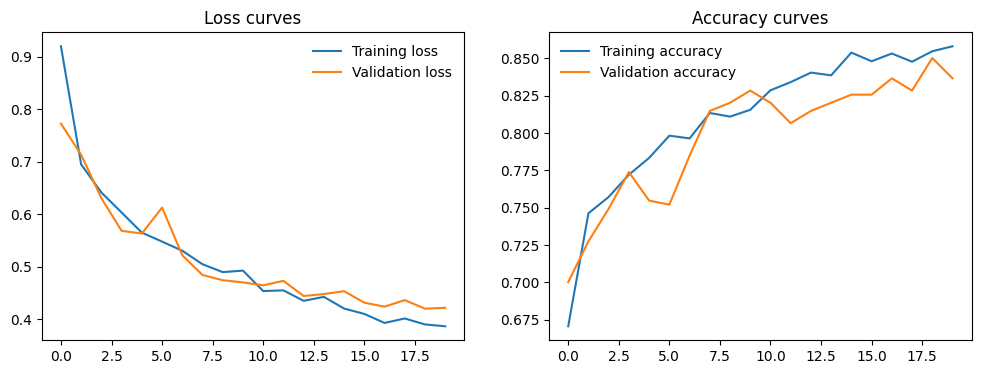

In [6]:
 
device = torch.device(args.device if torch.cuda.is_available() else "cpu")

    
train_csv_root = '/kaggle/input/aptos2019-blindness-detection/train.csv'
test_csv_root = '/kaggle/input/aptos2019-blindness-detection/test.csv'
train_img_root = '/kaggle/input/aptos2019-blindness-detection/train_images'
test_img_root = '/kaggle/input/aptos2019-blindness-detection/test_images'
    
# 划分训练集和验证集
train_labels_frame = pd.read_csv(train_csv_root)
train_df, val_df = train_test_split(train_labels_frame, test_size=0.1)

#数据增强
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),#随即裁剪，然后缩放
                                 transforms.RandomHorizontalFlip(),#以给定的概率随机水平旋转给定的PIL的图像
                                 transforms.ToTensor(),#将给定图像转为Tensor
                                 transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]),#归一化处理#串联多个transform操作
    "val": transforms.Compose([transforms.Resize(256),#调整尺寸
                               transforms.CenterCrop(224),#从图像中心裁剪图片
                               transforms.ToTensor(),#将给定图像转为Tensor
                               transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]),
   
    "test": transforms.Compose([transforms.Resize(256),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.45], std=[0.5, 0.5, 0.5])])
}

    # 实例化训练数据集
    #train_data_set = MyDataSet(images_path=train_images_path,
    #                           images_class=train_images_label,
    #                           transform=data_transform["train"])

    # 实例化验证数据集
    #val_data_set = MyDataSet(images_path=val_images_path,
    #                         images_class=val_images_label,
    #                         transform=data_transform["val"])
    
# 数据集和数据加载器
train_dataset = APTOSDataset(dataframe=train_df, root_dir=train_img_root, transform=data_transform["train"])
val_dataset = APTOSDataset(dataframe=val_df, root_dir=train_img_root, transform=data_transform["val"])
    #train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    #val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


batch_size = args.batch_size
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
print('Using {} dataloader workers every process'.format(nw))
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=nw,
                                           collate_fn=train_dataset.collate_fn)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         pin_memory=True,
                                         num_workers=nw,
                                         collate_fn=val_dataset.collate_fn)
model = vit_base_patch16_224_in21k(num_classes=5, has_logits=False).to(device)

if args.weights != "":
    assert os.path.exists(args.weights), "weights file: '{}' not exist.".format(args.weights)
    weights_dict = torch.load(args.weights, map_location=device)
    # 删除不需要的权重
    del_keys = ['head.weight', 'head.bias'] if model.has_logits \
        else ['pre_logits.fc.weight', 'pre_logits.fc.bias', 'head.weight', 'head.bias']
    for k in del_keys:
        del weights_dict[k]
    print(model.load_state_dict(weights_dict, strict=False))#model.load_state_dict(weights_dict, strict=False)加载的模型

if args.freeze_layers:
    for name, para in model.named_parameters():
        # 除head, pre_logits外，其他权重全部冻结
        if "head" not in name and "pre_logits" not in name:
            para.requires_grad_(False)
        else:
            print("training {}".format(name))

pg = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(pg, lr=args.lr, momentum=0.9, weight_decay=5E-5)#随机梯度下降算法
# Scheduler https://arxiv.org/pdf/1812.01187.pdf
lf = lambda x: ((1 + math.cos(x * math.pi / args.epochs)) / 2) * (1 - args.lrf) + args.lrf  # cosine 余弦退火降低学习率
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)#调整学习率

# 训练模型
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
for epoch in range(args.epochs):
    # train
    train_loss, train_acc = train_one_epoch(model=model,
                                            optimizer=optimizer,
                                            data_loader=train_loader,
                                            device=device,
                                            epoch=epoch)

    scheduler.step()

    # validate
    val_loss, val_acc = evaluate(model=model,
                                 data_loader=val_loader,
                                 device=device,
                                 epoch=epoch)
        
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

       #torch.save(model.state_dict(), "./weights/model-{}.pth".format(epoch))
# 绘制损失曲线和准确率曲线


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Validation loss')
ax1.legend(frameon=False)
ax1.set_title("Loss curves")

ax2.plot(train_accuracies, label='Training accuracy')
ax2.plot(val_accuracies, label='Validation accuracy')
ax2.legend(frameon=False)
ax2.set_title("Accuracy curves")

    # 保存图像到文件
plt.savefig('loss_and_accuracy_curves.png', dpi=300)

    # 显示图像
plt.show()

In [7]:
# 保存测试集的预测结果
test_labels_frame = pd.read_csv(test_csv_root)
test_dataset = APTOSDataset(dataframe=test_labels_frame, root_dir=test_img_root,transform=data_transform["val"], has_labels=False)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          pin_memory=True,
                                          num_workers=nw)
model.eval()
pred_classes=[];

with torch.no_grad():
    # for images, _ in test_loader:
    model.eval()
    for images, labels in tqdm(test_loader, desc='test'):
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        pred_classes.extend(predicted.cpu().numpy())
      
# 保存预测结果到csv文件
submission = pd.DataFrame({'id_code': test_dataset.labels_frame['id_code'], 'diagnosis': pred_classes})
submission.to_csv('submission.csv', index=False)



test: 100%|██████████| 241/241 [01:27<00:00,  2.75it/s]
